<a href="https://colab.research.google.com/github/naterattner/data71200/blob/master/project_3/data71200_summer24_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python notebook for project 3: https://bbhosted.cuny.edu/ultra/courses/_2383576_1/cl/outline

The goal for this assignment is two apply different types of unsupervised learning techniques on the dataset created in Project 1.

I'll be using this dataset containing estimations of obesity levels based on eating habits and physical condition: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [277]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

!pip install -U scikit-learn==1.4
!pip install mglearn
import mglearn

## Step 1: Load data, including testing/training split from Project 1

We will perform four steps in this section:
- Load the dataset from UCI
- Performing one-hot encoding on categorical features
- Split the data into a testing and training set
- Scale the data using StandardScaler

#### Load data from UCI

In [278]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# data (as pandas dataframes)
features = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
targets = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

### Perform one-hot encoding
Because the dataset contains categorical variables, we will first perform one-hot encoding. This is done on a Dataframe containing all data to ensure categorical values are represented in the same way in both the testing and training sets.

Once one-hot encoding is done, we split the data into testing and training sets.

In [279]:
# Encode the categorical features
data_dummies = pd.get_dummies(features, dtype=int)

# Encode the target variable using LabelEncoder
# This encodes labels that were in the target data with values
# from 0 through n_classes-1, so 0 through 6 in this case

from sklearn.preprocessing import LabelEncoder

# 'NObeyesdad' is the target column
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets['NObeyesdad'])

#### Split into testing and training sets

In [280]:
X = data_dummies
y = targets_encoded
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (2111, 31) y.shape: (2111,)


In [281]:
# From project 1 we know the data is fairly evenly distributed,
# but we can still use stratified sampling on the target to avoid sampling bias

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42,test_size=0.2)

In [282]:
# Check that the strafied sampling worked -- the distribution of targets should be the same in each dataset

def getArrayValueCounts(array):
  unique, counts = np.unique(array, return_counts=True)
  total_count = counts.sum()
  shares = counts / total_count

  print("Unique values:", unique)
  print("Counts:", counts)
  print("Shares:", shares)

print('Test')
getArrayValueCounts(y_test)
print("")
print('Train')
getArrayValueCounts(y_train)

Test
Unique values: [0 1 2 3 4 5 6]
Counts: [54 58 70 60 65 58 58]
Shares: [0.12765957 0.13711584 0.16548463 0.14184397 0.1536643  0.13711584
 0.13711584]

Train
Unique values: [0 1 2 3 4 5 6]
Counts: [218 229 281 237 259 232 232]
Shares: [0.12914692 0.13566351 0.16646919 0.14040284 0.15343602 0.13744076
 0.13744076]


#### Scale the data

In [283]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 2: PCA for feature selection

Two tasks in this section:
- Show how many features do you need to retain to capture 95% of the variance
- Evaluate whether this improves your best-performing model from Project 2


#### Features to explain 95% of variance

We will do this on the unscaled and then the scaled data

In [284]:
from sklearn.decomposition import PCA

# keep components to explain 95% of the variance
pca_unscaled = PCA(n_components=0.95)

# fit PCA model to data
pca_unscaled.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(str(len(pca_unscaled.explained_variance_ratio_)) + ' features')
print(pca_unscaled.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
2 features
[0.93988132 0.05429352]


Text(0, 0.5, 'Principal components')

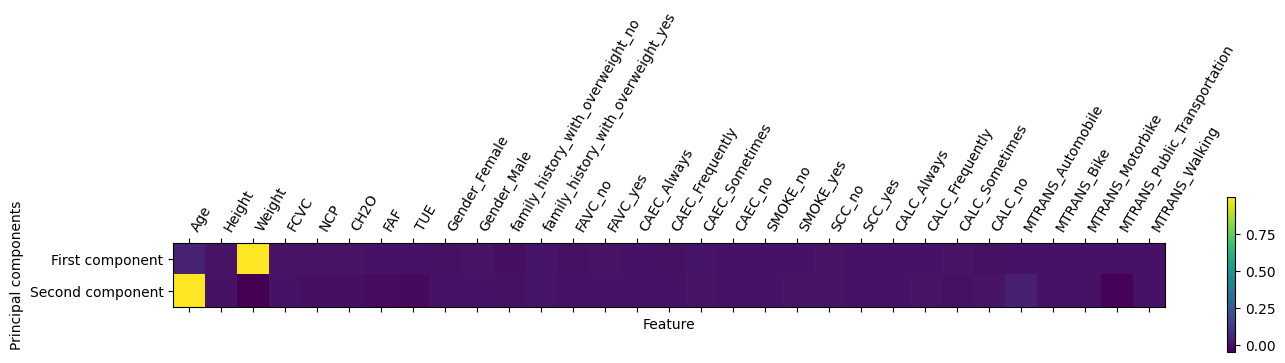

In [285]:
# plot the principal components
plt.matshow(pca_unscaled.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(data_dummies.columns)),
           data_dummies.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

With unscaled data, we need two features to retain 95% of the variance



In [286]:
# keep components to explain 95% of the variance using the scaled data this time
pca_scaled = PCA(n_components=0.95)

# fit PCA model to data
pca_scaled.fit(X_train_scaled)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(str(len(pca_scaled.explained_variance_ratio_)) + ' features')
print(pca_scaled.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
20 features
[0.13637523 0.08868986 0.07871772 0.06957283 0.06369763 0.06034785
 0.05121554 0.04711266 0.04243443 0.03982594 0.03677446 0.03587652
 0.03265677 0.03159093 0.03042904 0.02932461 0.02568618 0.02290776
 0.02236284 0.02043113]


Text(0, 0.5, 'Principal components')

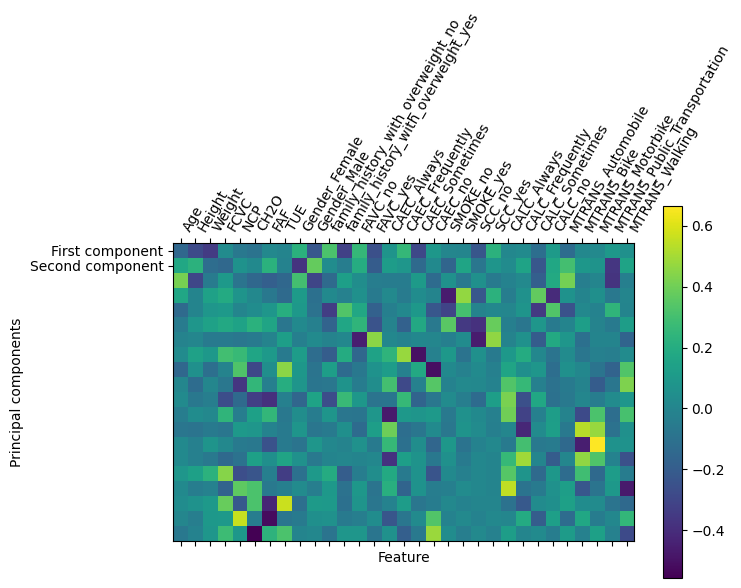

In [287]:
# plot the principal components
plt.matshow(pca_scaled.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(data_dummies.columns)),
           data_dummies.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

With scaled data, we need 20 features to retain 95% of the variance

#### Evaluate whether this improves best-performing model from project 2

The best-performing model from project 2 was a random forest with parameters of {'max_depth': None, 'n_estimators': 200}. This returned an accuracy of 93.6% on the test set, as seen below.

In [288]:
# Set up random forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=2)

forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.936


Now we set up an instance of PCA with two principal components of the unscaled data, and run the random forest on it.



In [289]:
pca_2_unscaled = PCA(n_components=2)

# fit on and transforming the training set and then transform the test set
X_train_pca_unscaled = pca_2_unscaled.fit_transform(X_train)
X_test_pca_unscaled = pca_2_unscaled.transform(X_test)

In [290]:
forest.fit(X_train_pca_unscaled, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train_pca_unscaled, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test_pca_unscaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.804


This accuracy of 80.4% on the test set is worse than the random forest performed on the original data.

Next we set up an instance of PCA with 20 principal components of the scaled data, and run the random forest on it.




In [291]:
pca_20_scaled = PCA(n_components=20)

# fit on and transforming the training set and then transform the test set
X_train_pca_scaled = pca_20_scaled.fit_transform(X_train_scaled)
X_test_pca_scaled = pca_20_scaled.transform(X_test_scaled)

In [292]:
forest.fit(X_train_pca_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train_pca_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test_pca_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.825


This accuracy of 82.5% on the test set is worse than the random forest performed on the original data. This is, however, stronger than the random forest performed on the unscaled PCA data.

### Step 3: Apply 3-types of clustering on your data and visualize the output of each both with and without PCA run on it first. Calculate both ARI and Silhouette Coefficient for all six of the combinations.

#### k-Means (use an elbow visualization to determine the optimal numbers of clusters)

#### Run on original data


##### Clustering

Text(0, 0.5, 'Feature 1')

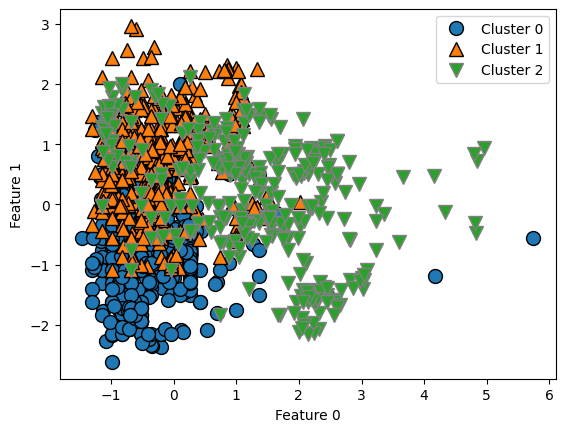

In [293]:
# import library
from sklearn.cluster import KMeans

# instantiate an instance of k-Means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

# get assignments (labels)
assignments=kmeans.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##### Elbow visualization

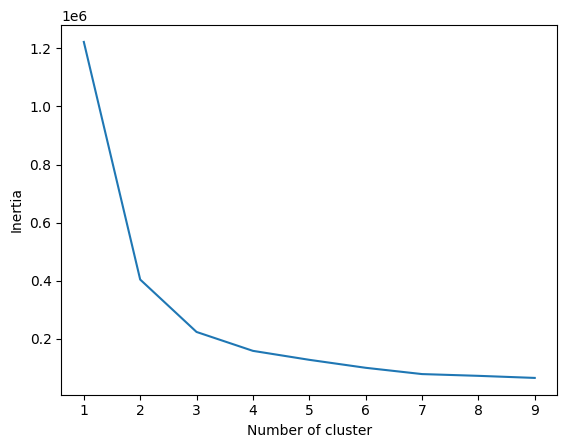

In [294]:
# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Here we look for the value of k at the “elbow,” or the point after which the inertia starts decreasing in a linear fashion. For this data the optimal number of clusters is 3.

#### Run on data after PCA

##### Clustering



Text(0, 0.5, 'Feature 1')

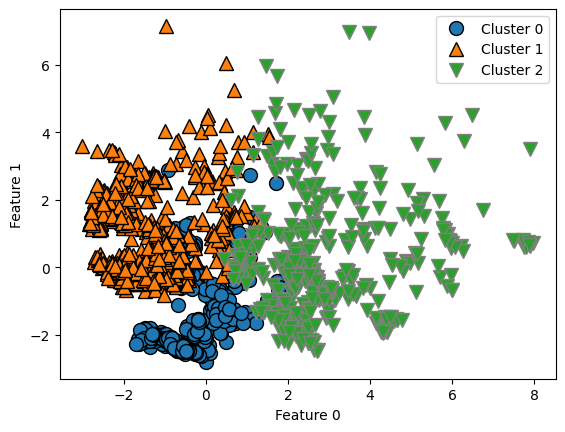

In [295]:
# instantiate an instance of k-Means
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(X_train_pca_scaled)

# get assignments (labels)
assignments_pca=kmeans_pca.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], assignments_pca)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Elbow visualization

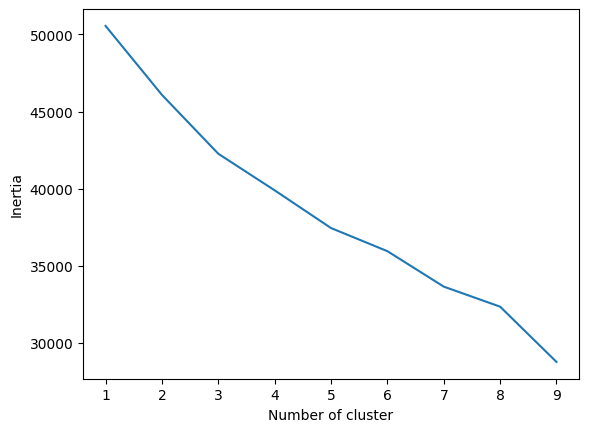

In [296]:
# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(X_train_pca_scaled)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

 For this data the optimal number of clusters is 6.

### Agglomerate/Hierarchical clustering

#### Original data

Text(0, 0.5, 'Feature 1')

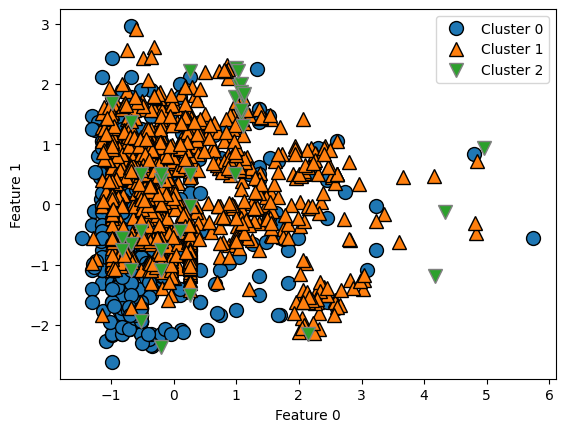

In [297]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train_scaled)

mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Run on data after PCA

Text(0, 0.5, 'Feature 1')

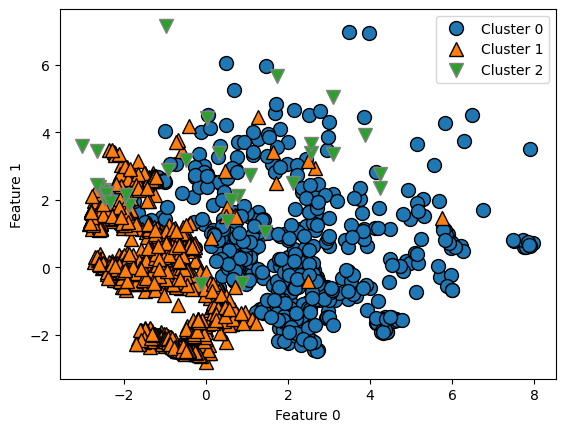

In [298]:
aggPCA = AgglomerativeClustering(n_clusters=3)
assignment = aggPCA.fit_predict(X_train_pca_scaled)

mglearn.discrete_scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### DBSCAN

#### Run on original data

Text(0, 0.5, 'Feature 1')

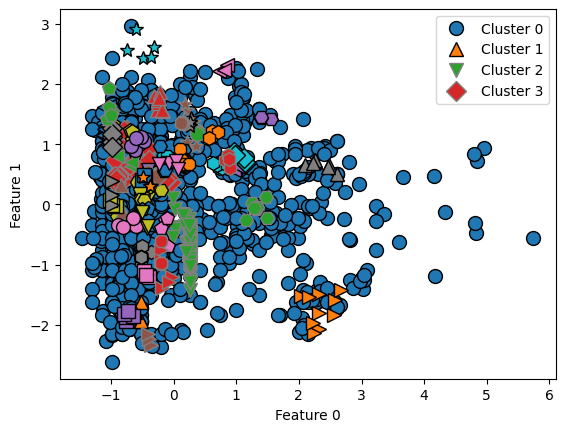

In [299]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=3,eps=0.5)
clusters = dbscan.fit_predict(X_train_scaled)

# plot the cluster assignments
mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Run on data after PCA

Text(0, 0.5, 'Feature 1')

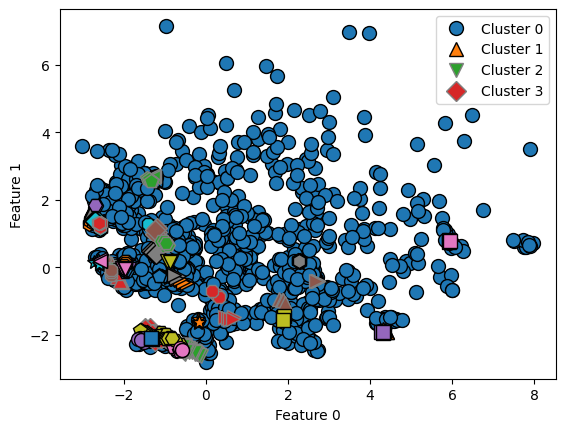

In [300]:
dbscanPCA = DBSCAN(min_samples=3,eps=0.5)
clustersPCA = dbscanPCA.fit_predict(X_train_pca_scaled)

# plot the cluster assignments
mglearn.discrete_scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### ARI and Silhouette Coefficient for all six of our combinations (three types of clustering, before and after PCA)



#### ARI - original data

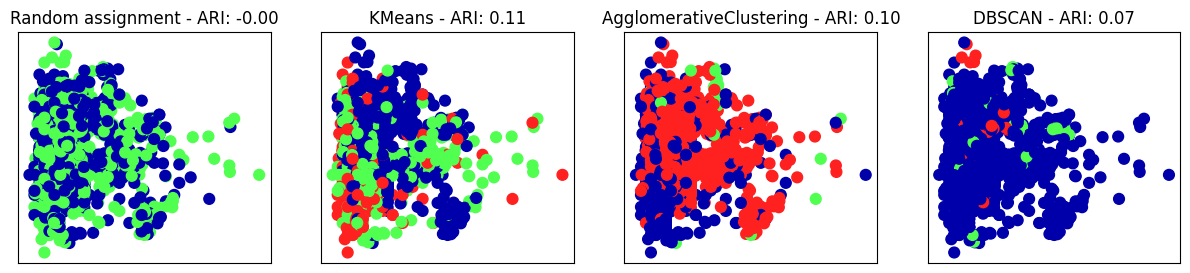

In [301]:
from sklearn.metrics.cluster import adjusted_rand_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=3)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_scaled)
    ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

### ARI - PCA data

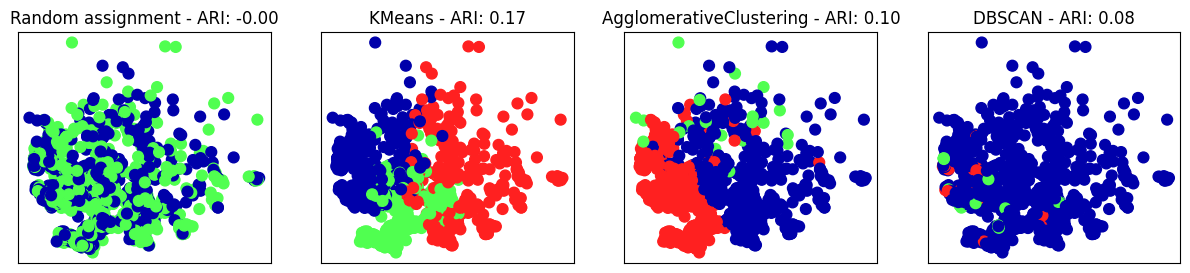

In [302]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=3)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_pca_scaled))

# plot random assignment
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_pca_scaled)
    ax.scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

### Silhouette Coefficient - Original Data

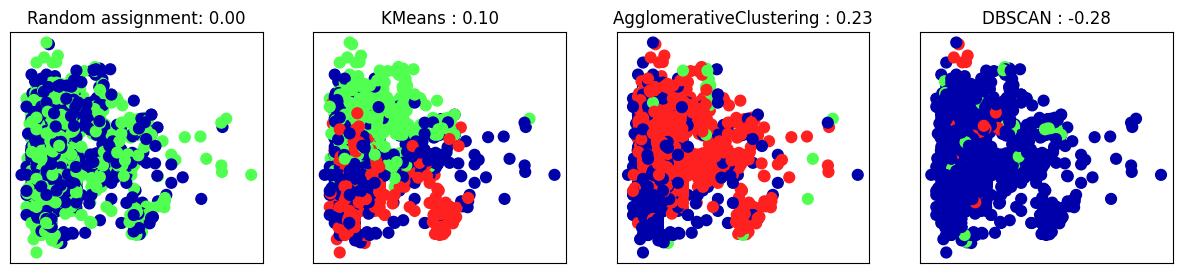

In [303]:
from sklearn.metrics.cluster import silhouette_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_scaled))

# plot random assignment
axes[0].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=3)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_scaled, clusters)))

#### Silhouette Coefficient - PCA

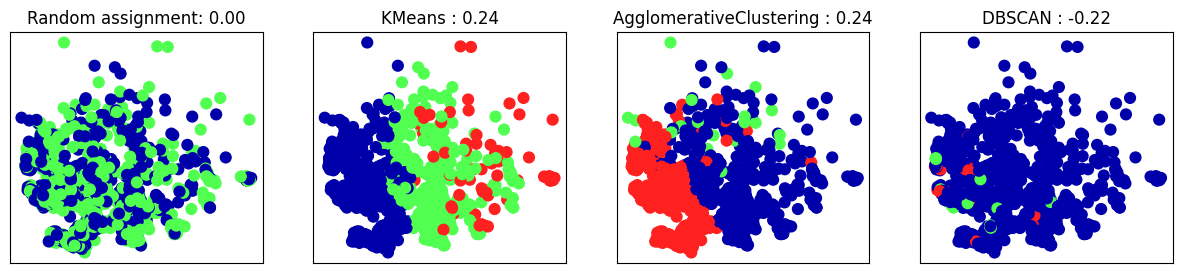

In [304]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_pca_scaled))

# plot random assignment
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_pca_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=3)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_pca_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train_pca_scaled, clusters)))

## Clustering attempts with breast cancer data

Based on the ARI and silhouette coefficient scores, the obesity dataset data does not appear to have clustered well. I'd like to see if these approaches work better with scikit learn's breast cancer dataset.

### Step 1: Load data, split into testing/training, and scale

In [305]:
#Load data

from sklearn.datasets import load_breast_cancer
cancer_dataset = load_breast_cancer()

In [306]:
# Split into test/training

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    cancer_dataset.data, cancer_dataset.target, stratify=cancer_dataset.target, random_state=66,test_size=0.2)

In [307]:
# Scale data

scaler = StandardScaler()
X_train_cancer_scaled = scaler.fit_transform(X_train_cancer)
X_test_cancer_scaled = scaler.transform(X_test_cancer)

### Step 2: PCA for feature selection
Two tasks in this section:

- Show how many features do you need to retain to capture 95% of the variance
- Evaluate whether this improves your best-performing model from Project 2

Note: I'm skipping the second step here, since I did not use this dataset in project 2.

In [308]:
# keep components to explain 95% of the variance
pca_cancer = PCA(n_components=0.95)

# fit PCA model to data
pca_cancer.fit(X_train_cancer_scaled)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(str(len(pca_cancer.explained_variance_ratio_)) + ' features')
print(pca_cancer.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
10 features
[0.44837054 0.18406119 0.09561047 0.06684428 0.05575205 0.03893997
 0.02298186 0.01514408 0.01315435 0.01135716]


10 features required to retain 95% of the variance

Text(0, 0.5, 'Principal components')

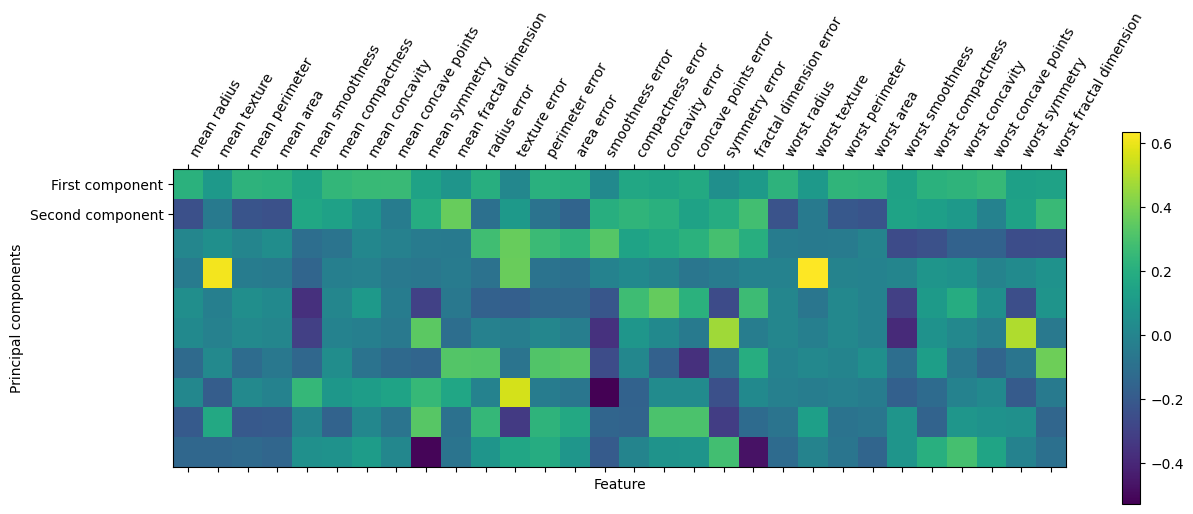

In [309]:
# plot the principal components
plt.matshow(pca_cancer.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer_dataset.feature_names)),
           cancer_dataset.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

### Step 3: Apply 3-types of clustering on your data and visualize the output of each both with and without PCA run on it first. Calculate both ARI and Silhouette Coefficient for all six of the combinations.

In [310]:
#Set up PCA data for use in clustering

pca_10 = PCA(n_components=10)

# fit on and transforming the training set and then transform the test set
X_train_cancer_pca = pca_10.fit_transform(X_train_cancer_scaled)
X_test_cancer_pca = pca_10.transform(X_test_cancer_scaled)

#### K-means

#### Run on original data

Text(0, 0.5, 'Feature 1')

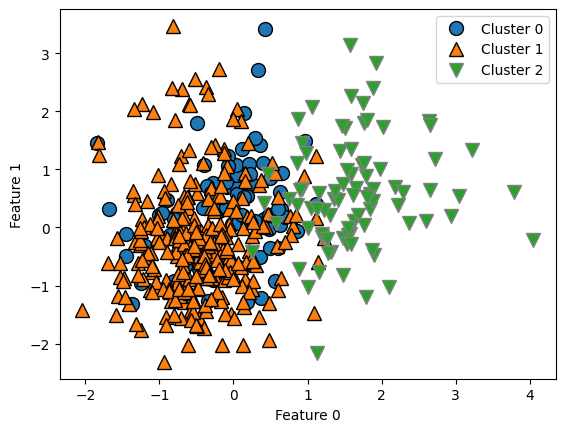

In [311]:
# instantiate an instance of k-Means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_cancer_scaled)

# get assignments (labels)
assignments=kmeans.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

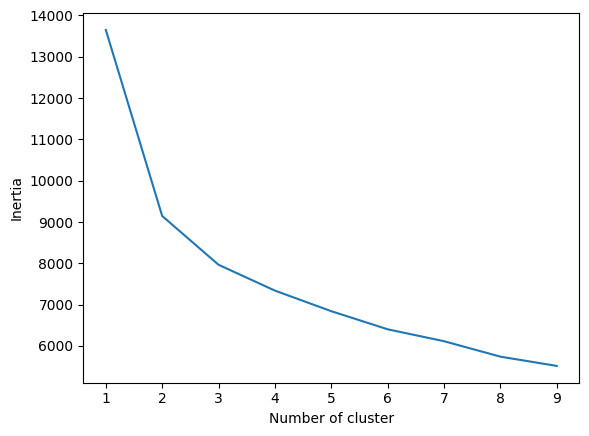

In [312]:
# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(X_train_cancer_scaled)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Optimal number appears to be 3.

#### Run on PCA data

Text(0, 0.5, 'Feature 1')

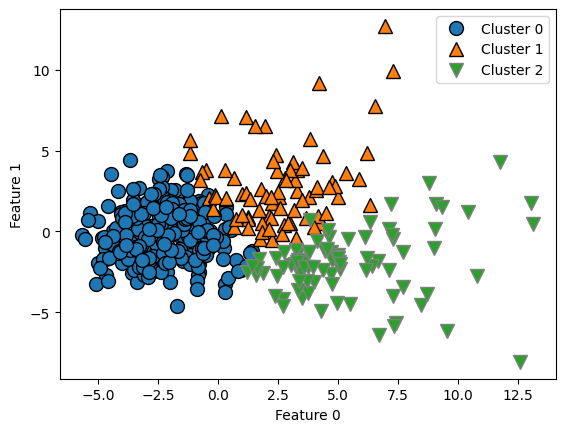

In [313]:
# instantiate an instance of k-Means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_cancer_pca)

# get assignments (labels)
assignments=kmeans.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

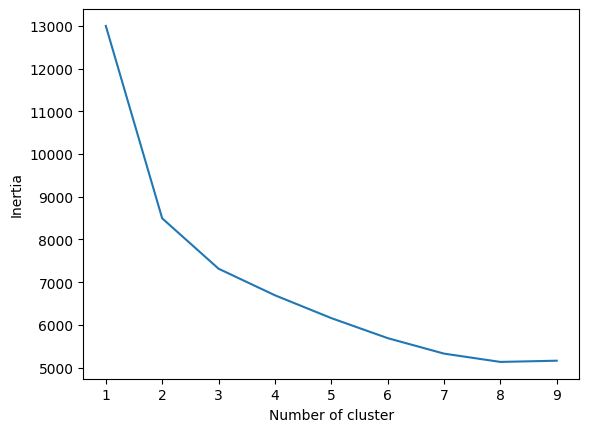

In [314]:
# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(X_train_cancer_pca)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Optimal number appears to be 3 again.

### Agglomerate/Hierarchical clustering

#### Original data

Text(0, 0.5, 'Feature 1')

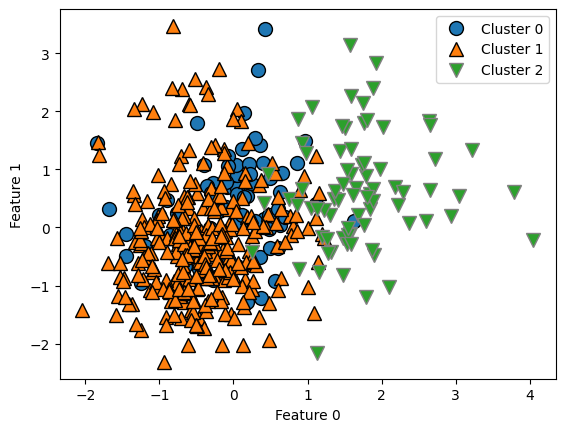

In [315]:
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train_cancer_scaled)

mglearn.discrete_scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Run on data after PCA

Text(0, 0.5, 'Feature 1')

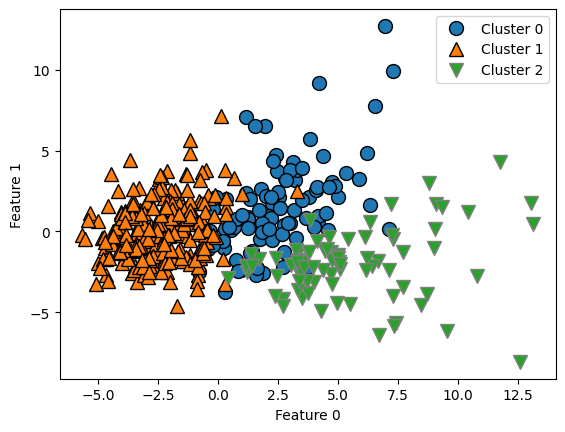

In [316]:
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train_cancer_pca)

mglearn.discrete_scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### DBScan

#### Run on original data

Text(0, 0.5, 'Feature 1')

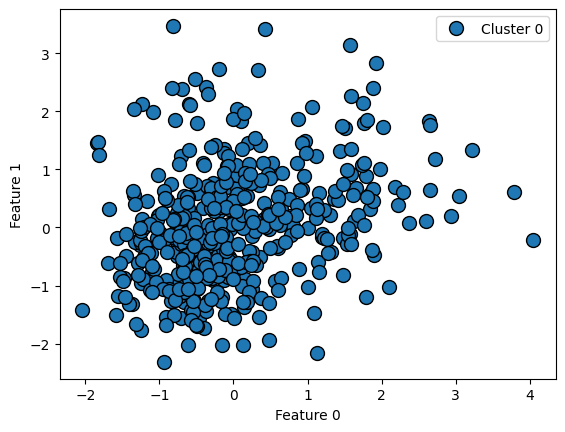

In [317]:
dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X_train_cancer_scaled)

# plot the cluster assignments
mglearn.discrete_scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

#### Run on data after PCA

Text(0, 0.5, 'Feature 1')

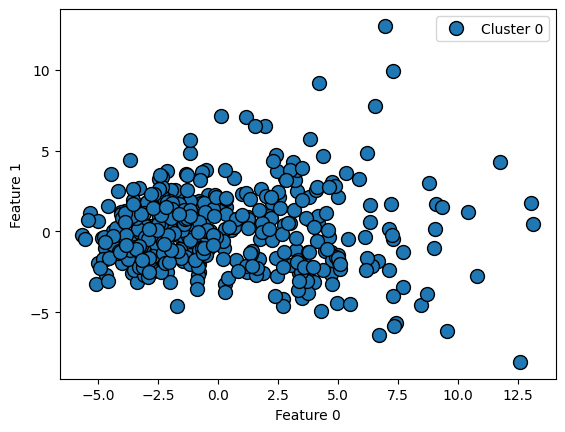

In [318]:
dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X_train_cancer_pca)

# plot the cluster assignments
mglearn.discrete_scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### ARI and Silhouette Coefficient for the six breat cancer dataset combinations

#### ARI - original data

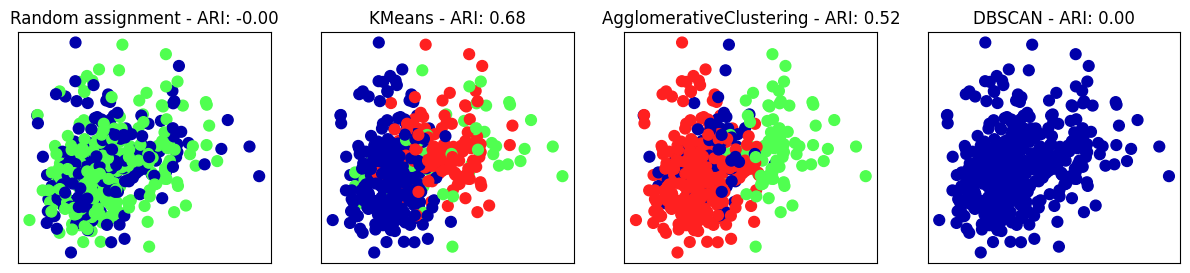

In [319]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=2)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_cancer_scaled))

# plot random assignment
axes[0].scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train_cancer, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_cancer_scaled)
    ax.scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train_cancer, clusters)))

### ARI - PCA data

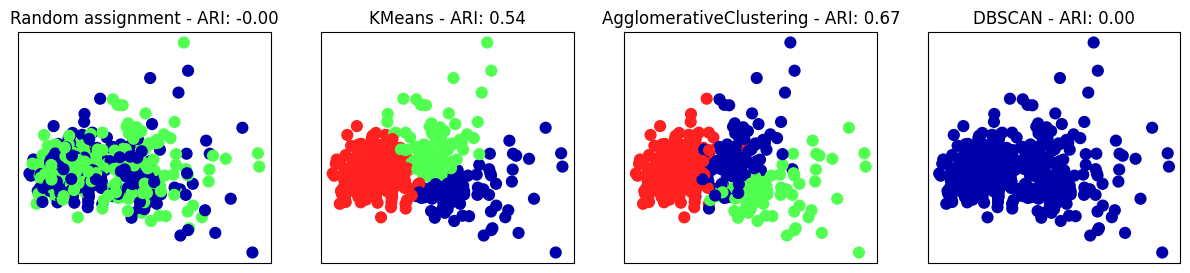

In [320]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=2)]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_cancer_pca))

# plot random assignment
axes[0].scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train_cancer, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train_cancer_pca)
    ax.scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train_cancer, clusters)))

### Silhouette coefficient - original data

<ipython-input-321-95ac282ca798>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], cmap=mglearn.cm3,


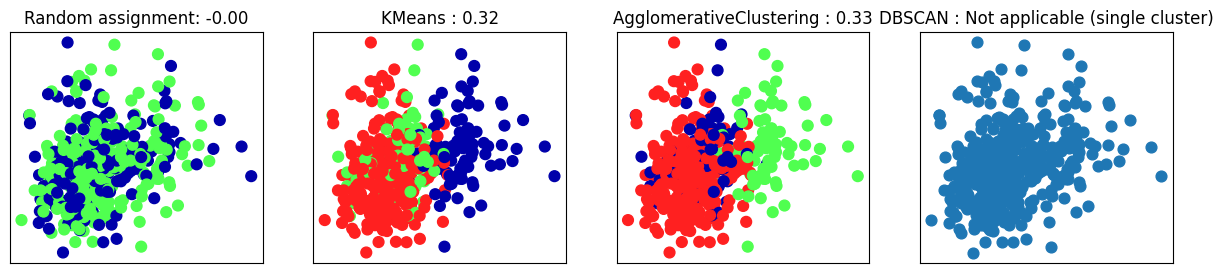

In [321]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_cancer_scaled))

# plot random assignment
axes[0].scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_cancer_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=2)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_cancer_scaled)

    # Handle cases where only one cluster is identified
    if len(np.unique(clusters)) > 1:
        # plot the cluster assignments and cluster centers
        ax.scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
                   s=60)
        ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                          silhouette_score(X_train_cancer_scaled, clusters)))
    else:
        ax.scatter(X_train_cancer_scaled[:, 0], X_train_cancer_scaled[:, 1], cmap=mglearn.cm3,
                   s=60)
        ax.set_title("{} : Not applicable (single cluster)".format(algorithm.__class__.__name__))

#### Silhouette coefficient - PCA

<ipython-input-322-28f883584fc7>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], cmap=mglearn.cm3,


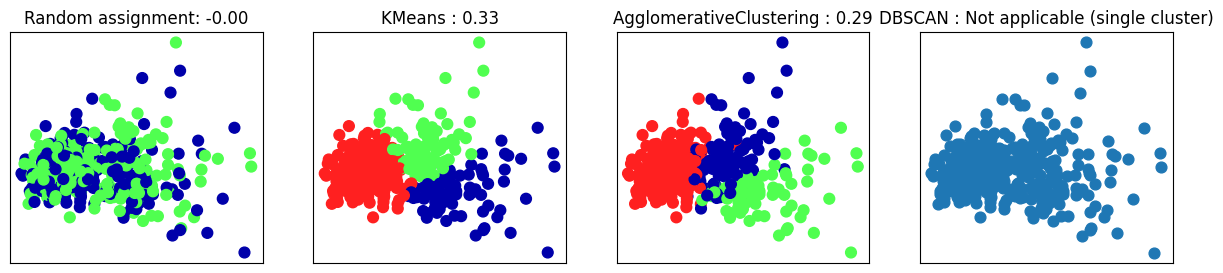

In [322]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_cancer_pca))

# plot random assignment
axes[0].scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train_cancer_pca, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3), DBSCAN(min_samples=2)]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train_cancer_pca)

    # Handle cases where only one cluster is identified
    if len(np.unique(clusters)) > 1:
        # plot the cluster assignments and cluster centers
        ax.scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], c=clusters, cmap=mglearn.cm3,
                   s=60)
        ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                          silhouette_score(X_train_cancer_pca, clusters)))
    else:
        ax.scatter(X_train_cancer_pca[:, 0], X_train_cancer_pca[:, 1], cmap=mglearn.cm3,
                   s=60)
        ax.set_title("{} : Not applicable (single cluster)".format(algorithm.__class__.__name__))

The higher ARI scores and silhouette coefficients for the breast cancer dataset suggest that this dataset lends itself better to clustering than the UCI obesity dataset.

An ARI score of 0.67 on the PCA data for the agglomerate clustering method is fairly strong, for example.